In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as ma

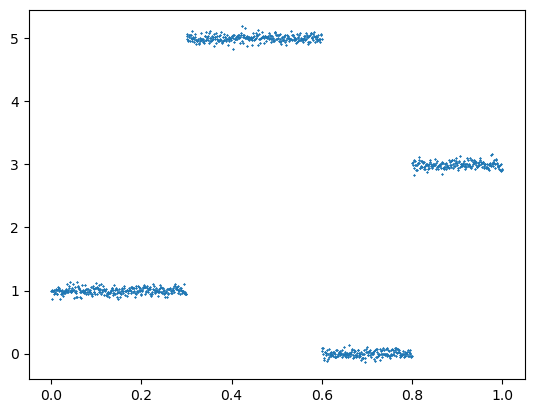

In [199]:
f = np.loadtxt('noisy_signal.csv')
axis = np.linspace(0, 1, num = len(f))




fig, plt_s = plt.subplots()
plt_s.plot(axis, f,'x', markersize = 1)

In [315]:

def lipschitz_bound(n, gamma):
    ''' Estimate a sensible lipschitz bound for the hessian of the denoising function, with n elements.
    '''


    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]

    
    
    Ahat = np.c_[A, np.zeros((n,n) )]
    Lhat = np.c_[-L , A]

    ##print( np.linalg.eig( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1 )) )

    return np.linalg.norm( np.transpose(Ahat) @ Ahat + np.transpose(Lhat) @ Lhat +max(gamma, 1) )##, 'fro')




In [33]:
def solve_U(U, b):
    """
    Solve systems Ux_i=b_i for x_i with U upper triangular, i=1,2,...,k

    :param U: an mxm-dimensional numpy array, assumed upper triangular
    :param b: an mxk-dimensional numpy array, with ith column containing 
       b_i
    :return x: an mxk-dimensional numpy array, with ith column containing 
       the solution x_i

    """
    m,n = U.shape
    x = b.copy()
    ## if this is only 1, transform vector into a interpretable matrix
    if len(x.shape) == 1:
        x = x.reshape((n,1)) 

    
    if U.diagonal().prod() == 0:
        return 'non invertible matrix'
     
    x[n-1,:] = (1/U[n-1,n-1])*x[n-1,:] 

    for i in reversed(range (0,n-1)):
        x[i,:] =  (1/U[i,i])*(x[i,:] - np.dot( U[i, i+1:n],x[i+1:n]) )
    return x   


def householder_solve(A, b):
    """
    Given a real mxm matrix A, use the Householder transformation to solve
    Ax_i=b_i, i=1,2,...,k.

    :param A: an mxm-dimensional numpy array
    :param b: an mxk-dimensional numpy array whose columns are the \
    right-hand side vectors b_1,b_2,...,b_k.

    :return x: an mxk-dimensional numpy array whose columns are the \
    right-hand side vectors x_1,x_2,...,x_k.
    """
    m, n = A.shape
    Ahat = np.c_[A,b]

    m2,n2 = Ahat.shape

    for k in range(0,n): ## for n columns of A
        x = Ahat[k:m,k] ## subvector extracted from column k to transform into a almost zeros vector
        signo = 1
        if x[0] < 0:
            signo = -1
        e1 = np.eye((m-k), dtype = 'float')[:,0]
        v = signo* e1 * np.linalg.norm(x) + x
        
        v = v / np.linalg.norm(v) 
        
        
        Ahat[k:m,k:n2] = Ahat[k:m,k:n2] - 2 * np.outer(v, v@Ahat[k:m,k:n2] ) 
    
    x = solve_U(Ahat[0:n,0:n],Ahat[0:n,n:n2])
    
    return x

def householder_ls_denoise(b, l):
    """
    Given a real mxn matrix A and an m dimensional vector b, find the
    least squares solution to Ax = b.

    :param A: an mxn-dimensional numpy array
    :param b: an m-dimensional numpy array

    :return x: an n-dimensional numpy array
    """
    A = np.eye( len (b) )
    
    m,n = A.shape
    
    if len(b.shape) == 1:
        b.resize((m,1))

    L =  A - np.c_[np.zeros([len(b),1]) , np.eye( len (b))[:,:-1]  ]
    
    b2 = np.r_[ b, np.zeros((n,1)) ]
    A2 = np.r_[ A, ma.sqrt(float(l))*L ]
    
    
    x = householder_solve(A2,b2)
    

    
    return x[0:n]

In [335]:
def variational_denoise_decoupled(f, l, gamma, om, alpha, beta):
    '''
    Gradient descend to minimize the variational denoise function. This is a decoupled version
    with individual optimization of x and y.

    Input: 
    f = a vector with noisy signals.
    l = a scalar, penalization parameter, how strict we want to be with the smoothness of the denoising
    gamma = smoothing factor for approximation of norm-1
    omega = penalization for the stepwise function steps.
    
    
    Output:
    x = value of the function.

    '''

    ##  INITIALIZATION :problem initializes creating required variables and parameters ########################
    ###########################################################################################################
    ###########################################################################################################
    n = len(f)
    
    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]
    
    x = f.copy()
    y = L @ x
    z = np.ones(len(x), dtype = 'float')
    x.resize((len(x), 1))
    y.resize((len(y), 1))
    z.resize((len(z), 1))

    omega = om * np.concatenate( (np.zeros(len(x)),np.ones(len(x))) )
    
    Lb =  lipschitz_bound(n, gamma)


    A = np.eye( n )
    L =  A - np.c_[np.zeros([n,1]) , np.eye( n )[:,:-1] ]
    
    
    ##  FIRST ITERATION: required to assess the entry condition to descend loop ###############################
    ###########################################################################################################
    ###########################################################################################################
    M = np.eye(n) + l * L.T @ L
    b = f +l * L.T @ (y-z)
    xk = np.linalg.solve(M, b)
    xk.resize((len(xk), 1))


    
    for i in range(0, len(y)):
        Lr = L[i,:] ## fuera del while
        Lr.resize((n,1))
        t = Lr.T @ xk + float(z[i])
        y[i] =   (t / np.abs(t) ) * max(np.abs(t) - om/l, 0) ## y can be overwritten because I no longer need yk

    
    
    
    iter = 0 
    while np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10)  > .00001 and iter < 10000: ##<--------------------------------------------iteración sobre x
        iter = iter + 1
        
        if n % 100 == 0:
            print(iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10) )
        
        x = xk
        z = +  (L @ xk - y) ## y = yk, but an in place calc was done to avoid wasting space.

        
            

        M = np.eye(n) + l * L.T @ L
        b = f + l * L.T @ (y-z)
        xk = np.linalg.solve(M, b)
        xk.resize((len(xk), 1))

        for i in range(0, len(y)):
            Lr = L[i,:]  ## dentro del while
            Lr.resize((n,1))
            t = Lr.T @ xk + float(z[i]) ## actualized x old z
            y[i] =   (t / np.abs(t) ) * max(np.abs(t) - om/l, 0) ## y can be overwritten because I no longer need yk
            
    print(iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10) )
    return x, y

In [339]:
n = 999



f2 = np.array([1.02,.98,.99,1.012,1.001, 5.15,4.95,5.2,4.95,5.001, 0.01,-0.01,0.1,0.03,-.003,2.99,3.01,3.011, 2.992,3.1])

f2 = f[0:n]

x = np.average(f2) * np.ones(len(f2) )
y = np.std(f2) * np.ones(len(f2))
l = 10
z = np.zeros(len(f2))
gamma = 100
om = 2
alpha = .8
beta = .7



f2.resize((len(f2), 1))
z.resize((len(z), 1))

x2, y2 = variational_denoise_decoupled(f2, l, gamma, om, alpha, beta)


axis = np.linspace(0, 1, num = len(f2))
fig, plt_s = plt.subplots()
plt_s.plot(axis, f2,'x', markersize = .5)
plt_s.plot(axis, x)
plt_s.plot(axis, x2)


fig, plt_s2 = plt.subplots()
plt_s2.plot(axis, f2,'x', markersize = 1)
plt_s2.plot(axis, y)
plt_s2.plot(axis, y2,'x')


#print(iter, np.linalg.norm(xk - x) / ( np.linalg.norm(xk)+ 1e-10), np.linalg.norm(grad), fu )


/var/folders/yb/t12gmr7j5332csvpymrkzw1m0000gn/T/ipykernel_54250/569313173.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = Lr.T @ xk + float(z[i])
/var/folders/yb/t12gmr7j5332csvpymrkzw1m0000gn/T/ipykernel_54250/569313173.py:82: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = Lr.T @ xk + float(z[i]) ## actualized x old z


KeyboardInterrupt: 